In [43]:
import pandas 
%matplotlib inline 
import matplotlib.pyplot as plt 

fast_relax = pandas.read_csv( '../data_sets/features/fast_relax.csv', index_col=0 ) 

# take lowest 5 by total system energy score and average the scores 
fast_relax = fast_relax.groupby( 'name' ).apply( lambda x: x.sort_values( 'total_score' ).head( 10 ).mean() ) 
#fast_relax.index = fast_relax.name 

print len( fast_relax ), 'rows total'
print fast_relax.sample( 5 ) 

199 rows total
       total_score  dslf_fa13     fa_atr    fa_dun   fa_elec  fa_intra_rep  \
name                                                                         
E406Q    -949.1676    -1.1369 -2470.5831  576.8261 -242.4687        5.0871   
A357A    -952.7640    -1.1942 -2470.4570  578.7278 -244.4415        5.1551   
Y166F    -951.6935    -1.1866 -2469.2958  577.7762 -242.5540        5.1107   
W407R    -948.6527    -1.1355 -2465.4242  577.3532 -242.3007        5.0420   
L108N    -952.0653    -1.2038 -2469.9650  579.0849 -243.0270        5.1086   

         fa_rep     fa_sol  hbond_bb_sc  hbond_lr_bb  hbond_sc  hbond_sr_bb  \
name                                                                          
E406Q  280.6363  1326.5030     -49.4032     -75.6388  -86.1837    -132.6046   
A357A  277.6062  1325.9420     -49.4900     -76.2942  -85.6631    -132.2435   
Y166F  275.6751  1325.0321     -50.0858     -76.3041  -84.7174    -131.4889   
W407R  275.3579  1327.7027     -50.1935    

In [44]:
my_cols = [ 'expression', 'tm', 'kcat', 'km', 'kcatkm' ] 
df = pandas.read_csv( '../data_sets/experimental_data/thermo_paper_data_set.csv', 
                     index_col=0, usecols=['w']+my_cols )

In [45]:
print len( df ) 
print df.sample( 5 ) 

126
       expression    tm   kcat     km    kcatkm
w                                              
H379T           0   NaN    NaN    NaN       NaN
T296E           0   NaN    NaN    NaN       NaN
E154D           1  38.7  878.0   3.46  254004.0
N220G           1  41.9    NaN    NaN       NaN
Y18A            1  37.2  197.0  31.55    6230.0


In [46]:
# make new data sets for each of the columns

data_sets = {}
for col in my_cols:
    my_data = df[ [ col ] ].dropna()
    print len( my_data ), 'samples for', col 
    data_sets.update( { col: my_data } ) 

126 samples for expression
62 samples for tm
69 samples for kcat
69 samples for km
78 samples for kcatkm


In [47]:
# let's see if we can predict soluble expression first, since it is the only one 
# that is naively a classification problem 

In [48]:
J = data_sets['expression'].join( fast_relax ).dropna()
y = J.expression
X = J.drop( 'expression', axis=1 ) 

print X.shape
print y.shape

(125, 18)
(125,)


([<matplotlib.axis.XTick at 0x1161d77d0>,
 <a list of 2 Text xticklabel objects>)

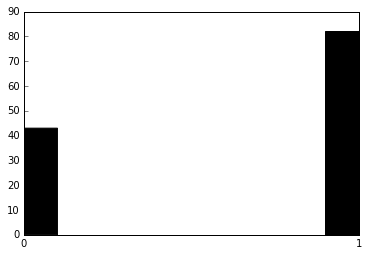

In [66]:
# unbalanced classes 
plt.hist( y, color='k' )
plt.xticks( [0,1] )

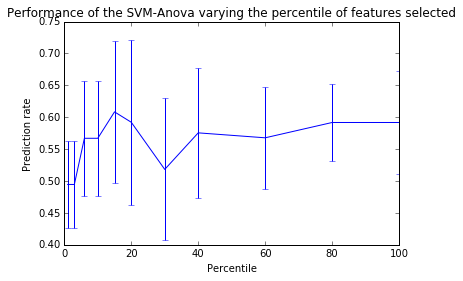

In [73]:
import numpy as np
from sklearn import svm, datasets, feature_selection, cross_validation, pipeline, preprocessing

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler() ), 
    ('anova', transform), 
    ('svc', svm.SVC(class_weight='balanced'))
])

# cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using all CPUs
    this_scores = cross_validation.cross_val_score(clf, X, y, n_jobs=-1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')
plt.show()

In [74]:
# OK, let's try Tm with the elastic net model 

In [76]:
J = data_sets['tm'].join( fast_relax ).dropna()
y = J.tm
X = J.drop( 'tm', axis=1 ) 

print X.shape
print y.shape

(61, 18)
(61,)


-0.443932464886 0.433231110818


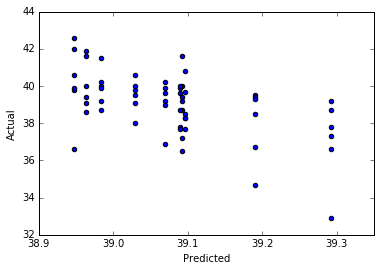

In [77]:
from sklearn import linear_model, cross_validation, pipeline, preprocessing
import numpy as np 

pln = pipeline.Pipeline([
    ( 'scaler', preprocessing.StandardScaler() ), 
    ( 'en', linear_model.ElasticNetCV() ),
])

scores = cross_validation.cross_val_score( pln, X, y, cv=10 ) 
preds = cross_validation.cross_val_predict( pln, X, y, cv=10 ) 
print scores.mean(), scores.std()

plt.scatter( preds, y )
plt.xlabel( 'Predicted' )
plt.ylabel( 'Actual' ) 

In [75]:
expression = pandas.read_csv( '../../data_sets/experimental_data/thermo_paper_data_set.csv', index_col='mutant', usecols=['mutant', 'expression'] )
ex_join = expression.join( df ).dropna().drop( 'name', axis=1 ) 
ex_join

,expression,total_score,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,omega,p_aa_pp,pro_close,rama,ref,yhh_planarity
A192S,1,-956.271,-1.201,-2463.898,572.674,-247.011,5.028,271.568,1326.660,-49.981,-76.914,-84.496,-131.064,38.895,-77.426,0.752,-25.878,-14.955,0.977
A192S,1,-953.167,-1.097,-2468.227,583.415,-244.709,5.217,269.979,1321.249,-48.307,-76.734,-85.001,-132.342,39.098,-75.250,0.716,-26.837,-14.955,0.619
A192S,1,-952.575,-1.156,-2461.429,576.813,-239.649,5.016,273.125,1320.468,-47.854,-77.887,-85.273,-132.853,36.622,-77.164,0.748,-27.971,-14.955,0.825
A192S,1,-951.242,-1.216,-2471.510,579.476,-243.571,5.022,279.373,1327.512,-51.675,-76.853,-87.921,-131.770,39.411,-77.336,0.881,-27.123,-14.955,1.013
A192S,1,-950.673,-1.169,-2474.958,576.911,-244.819,5.024,282.769,1331.609,-51.265,-76.100,-86.319,-133.082,38.147,-76.581,0.906,-27.558,-14.955,0.766
C167A,1,-956.431,-1.140,-2472.382,581.469,-245.402,5.298,275.156,1324.451,-51.583,-75.317,-86.598,-131.609,39.489,-78.225,0.847,-27.684,-14.017,0.817
C167A,1,-952.225,-1.219,-2466.651,570.056,-234.038,4.993,278.379,1318.526,-49.391,-76.883,-82.063,-132.219,38.234,-79.990,0.848,-27.664,-14.017,0.873
C167A,1,-950.490,-1.184,-2481.949,582.671,-242.250,5.190,278.713,1329.045,-49.949,-76.316,-84.170,-130.229,38.936,-79.528,1.044,-27.547,-14.017,1.049
C167A,1,-950.484,-1.170,-2471.248,581.717,-243.904,5.150,278.564,1325.796,-48.994,-76.546,-86.277,-132.748,38.673,-78.907,0.867,-28.216,-14.017,0.776
C167A,1,-950.397,-1.107,-2471.409,587.096,-246.016,5.231,274.442,1327.200,-51.656,-76.098,-86.691,-129.997,36.594,-79.009,0.831,-26.632,-14.017,0.841


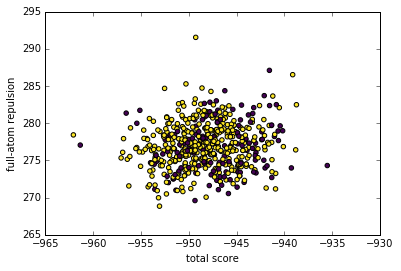

In [76]:
plt.scatter( ex_join.total_score, ex_join.fa_rep, c=ex_join.expression, cmap='viridis' )
plt.xlabel( 'total score' )
plt.ylabel( 'full-atom repulsion' ) 

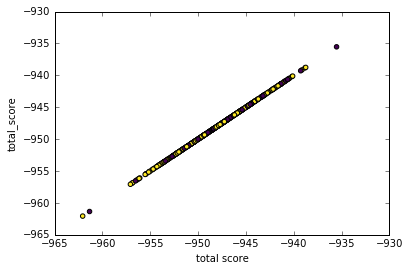

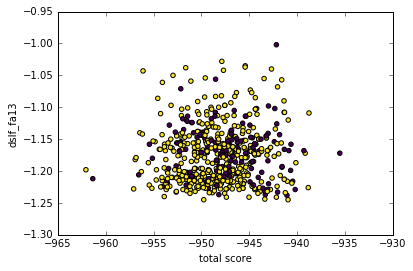

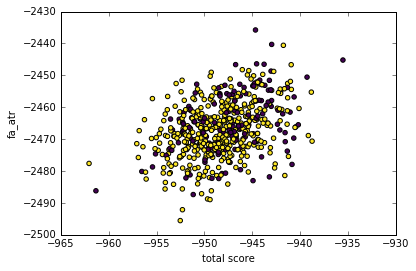

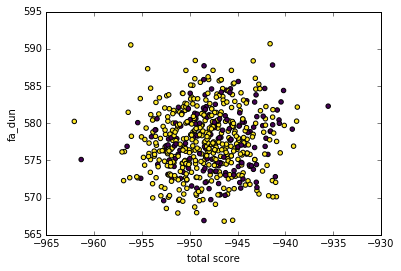

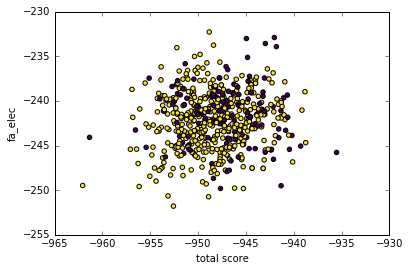

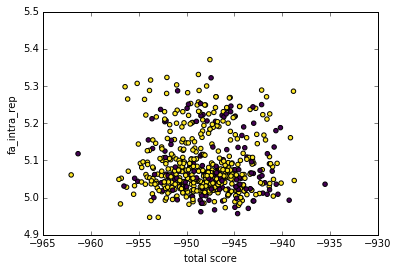

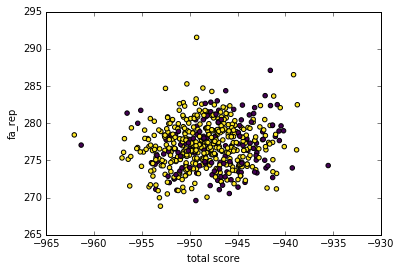

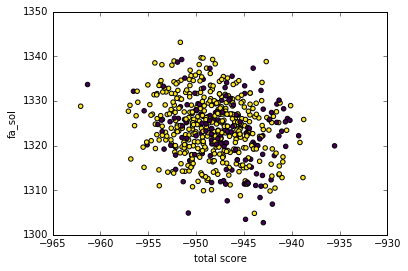

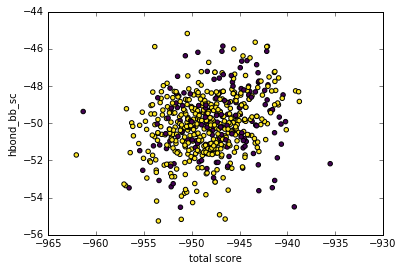

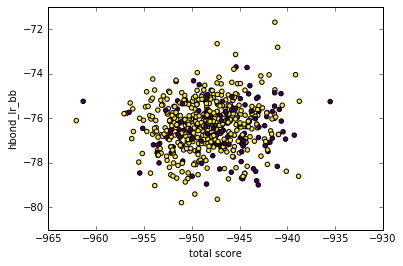

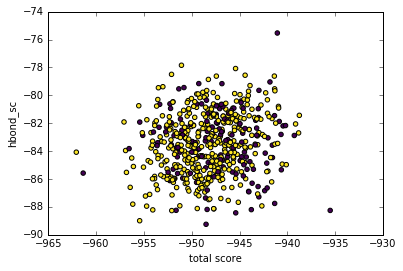

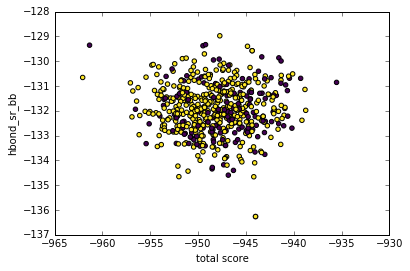

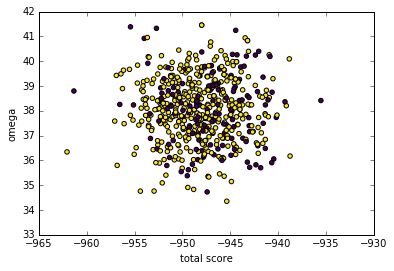

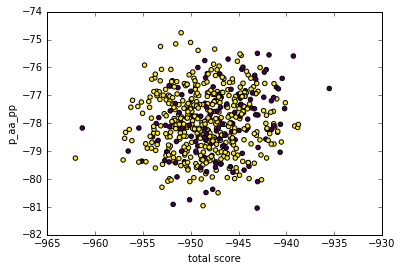

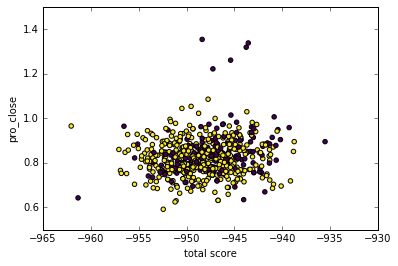

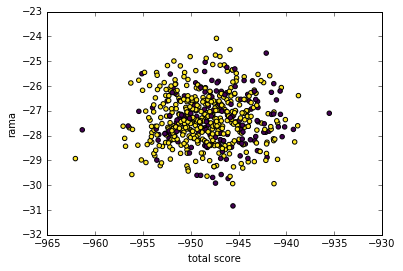

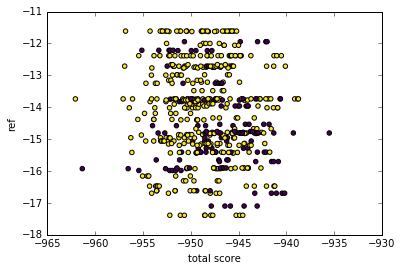

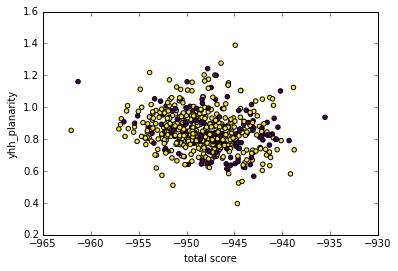

In [77]:
for feature in my_cols:
    
    if feature == 'name':
        break

    plt.scatter( ex_join.total_score, ex_join[ feature ], c=ex_join.expression, cmap='viridis' )
    plt.xlabel( 'total score' )
    plt.ylabel( feature ) 
    plt.show()

In [93]:
from sklearn import svm, decomposition, grid_search
from sklearn import linear_model, cross_validation, pipeline, preprocessing
import numpy as np 

y = ex_join.expression
X = ex_join.drop( 'expression', axis=1 ) 

pln = pipeline.Pipeline([
    ( 'scaler', preprocessing.StandardScaler() ), 
    ( 'pca', decomposition.PCA( whiten=True ) ), 
    ( 'svm', svm.SVC( class_weight='balanced' ) ),
])

param_grid = {
    'svm__C': [ .3, 3, 30 ], 
    'pca__n_components': [ 2, 3, 4, 8 ], 
    'svm__kernel': [ 'linear', 'rbf' ], 
}

grid = grid_search.GridSearchCV( pln, param_grid ) 
grid.fit( X, y )

print grid.best_score_

#preds = 

grid.predict?

# from sklearn.metrics import classification_report
# print classification_report( y, preds ) 


0.569642857143


In [85]:
X[ 'expression' ] = y 
X[ 'prediction' ] = preds 
X

,total_score,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,omega,p_aa_pp,pro_close,rama,ref,yhh_planarity,expression,prediction
A192S,-956.271,-1.201,-2463.898,572.674,-247.011,5.028,271.568,1326.660,-49.981,-76.914,-84.496,-131.064,38.895,-77.426,0.752,-25.878,-14.955,0.977,1,1
A192S,-953.167,-1.097,-2468.227,583.415,-244.709,5.217,269.979,1321.249,-48.307,-76.734,-85.001,-132.342,39.098,-75.250,0.716,-26.837,-14.955,0.619,1,1
A192S,-952.575,-1.156,-2461.429,576.813,-239.649,5.016,273.125,1320.468,-47.854,-77.887,-85.273,-132.853,36.622,-77.164,0.748,-27.971,-14.955,0.825,1,1
A192S,-951.242,-1.216,-2471.510,579.476,-243.571,5.022,279.373,1327.512,-51.675,-76.853,-87.921,-131.770,39.411,-77.336,0.881,-27.123,-14.955,1.013,1,1
A192S,-950.673,-1.169,-2474.958,576.911,-244.819,5.024,282.769,1331.609,-51.265,-76.100,-86.319,-133.082,38.147,-76.581,0.906,-27.558,-14.955,0.766,1,1
C167A,-956.431,-1.140,-2472.382,581.469,-245.402,5.298,275.156,1324.451,-51.583,-75.317,-86.598,-131.609,39.489,-78.225,0.847,-27.684,-14.017,0.817,1,1
C167A,-952.225,-1.219,-2466.651,570.056,-234.038,4.993,278.379,1318.526,-49.391,-76.883,-82.063,-132.219,38.234,-79.990,0.848,-27.664,-14.017,0.873,1,1
C167A,-950.490,-1.184,-2481.949,582.671,-242.250,5.190,278.713,1329.045,-49.949,-76.316,-84.170,-130.229,38.936,-79.528,1.044,-27.547,-14.017,1.049,1,1
C167A,-950.484,-1.170,-2471.248,581.717,-243.904,5.150,278.564,1325.796,-48.994,-76.546,-86.277,-132.748,38.673,-78.907,0.867,-28.216,-14.017,0.776,1,1
C167A,-950.397,-1.107,-2471.409,587.096,-246.016,5.231,274.442,1327.200,-51.656,-76.098,-86.691,-129.997,36.594,-79.009,0.831,-26.632,-14.017,0.841,1,1
